# Handling Imbalanced Data

## Learning Objectives
By the end of this notebook, you will be able to:
1. Recognize class imbalance problems
2. Apply class weights to handle imbalance
3. Implement SMOTE for synthetic data generation
4. Compare different imbalance handling strategies
5. Evaluate models with appropriate metrics




## Introduction: The Imbalanced Data Problem

Real-world datasets are often imbalanced, where one class significantly outweighs the other. This creates serious challenges for machine learning models.

**Why Imbalanced Data is Problematic:**
- **Models favor the majority class** to achieve high accuracy
- **Minority class gets ignored** despite being often more important
- **Standard metrics become misleading** (accuracy trap)
- **Business impact is severe** - we miss critical cases

**Real-World Examples:**
- **Fraud detection:** 99.9% legitimate transactions, 0.1% fraud
- **Medical diagnosis:** 95% healthy patients, 5% with disease
- **Customer churn:** 80% stay, 20% leave
- **Spam detection:** 90% legitimate emails, 10% spam

**Think About It:** If you're building a fraud detection system and 99.9% of transactions are legitimate, what accuracy would a "dumb" model that always predicts "legitimate" achieve? Is this useful?

In this notebook, we'll explore techniques to handle imbalanced data and build models that actually work for the minority class.


In [15]:
# Install required libraries if not already installed
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.under_sampling import RandomUnderSampler
    print("✅ imblearn library found!")
except ImportError:
    print("❌ imblearn not found. Installing...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "imbalanced-learn"])
    from imblearn.over_sampling import SMOTE
    from imblearn.under_sampling import RandomUnderSampler
    print("✅ imblearn installed successfully!")

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix)
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("Ready to handle imbalanced data!")


✅ imblearn library found!
Libraries imported successfully!
Ready to handle imbalanced data!


In [16]:
# Load and prepare the Telco Customer Churn dataset
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"

try:
    df = pd.read_csv(url)
    print("✅ Dataset loaded successfully!")
except:
    print("❌ Could not load from URL. Please check your internet connection.")

# Clean the data
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)

# Prepare data for modeling
features = ['tenure', 'MonthlyCharges', 'TotalCharges']
X = df[features]
y = (df['Churn'] == 'Yes').astype(int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Dataset shape: {df.shape}")
print(f"Features: {features}")
print(f"Training set: {X_train.shape[0]:,} customers")
print(f"Testing set: {X_test.shape[0]:,} customers")
print(f"Overall churn rate: {y.mean():.1%}")
print(f"Training churn rate: {y_train.mean():.1%}")
print(f"Testing churn rate: {y_test.mean():.1%}")


✅ Dataset loaded successfully!
Dataset shape: (7043, 21)
Features: ['tenure', 'MonthlyCharges', 'TotalCharges']
Training set: 5,634 customers
Testing set: 1,409 customers
Overall churn rate: 26.5%
Training churn rate: 26.5%
Testing churn rate: 26.5%


## Section 1: The Imbalance Problem - Creating an Extreme Example

Let's first see what happens with severely imbalanced data by creating an extreme example.


In [17]:
# Create an extremely imbalanced dataset (99% vs 1%)
# Take only 1% of the churn cases to create severe imbalance
churn_indices = np.where(y_train == 1)[0]
no_churn_indices = np.where(y_train == 0)[0]

# Keep only 1% of churn cases
n_churn_keep = max(1, len(churn_indices) // 100)  # Keep at least 1
selected_churn = np.random.choice(churn_indices, size=n_churn_keep, replace=False)

# Create imbalanced dataset
imbalanced_indices = np.concatenate([no_churn_indices, selected_churn])
X_imbalanced = X_train.iloc[imbalanced_indices]
y_imbalanced = y_train.iloc[imbalanced_indices]

print(f"Original training set: {len(y_train):,} samples")
print(f"Imbalanced training set: {len(y_imbalanced):,} samples")
print(f"Original churn rate: {y_train.mean():.1%}")
print(f"Imbalanced churn rate: {y_imbalanced.mean():.1%}")

# Train model on imbalanced data
model_imbalanced = LogisticRegression(random_state=42)
model_imbalanced.fit(X_imbalanced, y_imbalanced)

# Make predictions
y_pred_imbalanced = model_imbalanced.predict(X_test)
y_pred_proba_imbalanced = model_imbalanced.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy_imb = accuracy_score(y_test, y_pred_imbalanced)
precision_imb = precision_score(y_test, y_pred_imbalanced)
recall_imb = recall_score(y_test, y_pred_imbalanced)
f1_imb = f1_score(y_test, y_pred_imbalanced)

print(f"\nImbalanced Model Performance:")
print(f"Accuracy: {accuracy_imb:.3f}")
print(f"Precision: {precision_imb:.3f}")
print(f"Recall: {recall_imb:.3f}")
print(f"F1 Score: {f1_imb:.3f}")


Original training set: 5,634 samples
Imbalanced training set: 4,153 samples
Original churn rate: 26.5%
Imbalanced churn rate: 0.3%

Imbalanced Model Performance:
Accuracy: 0.735
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


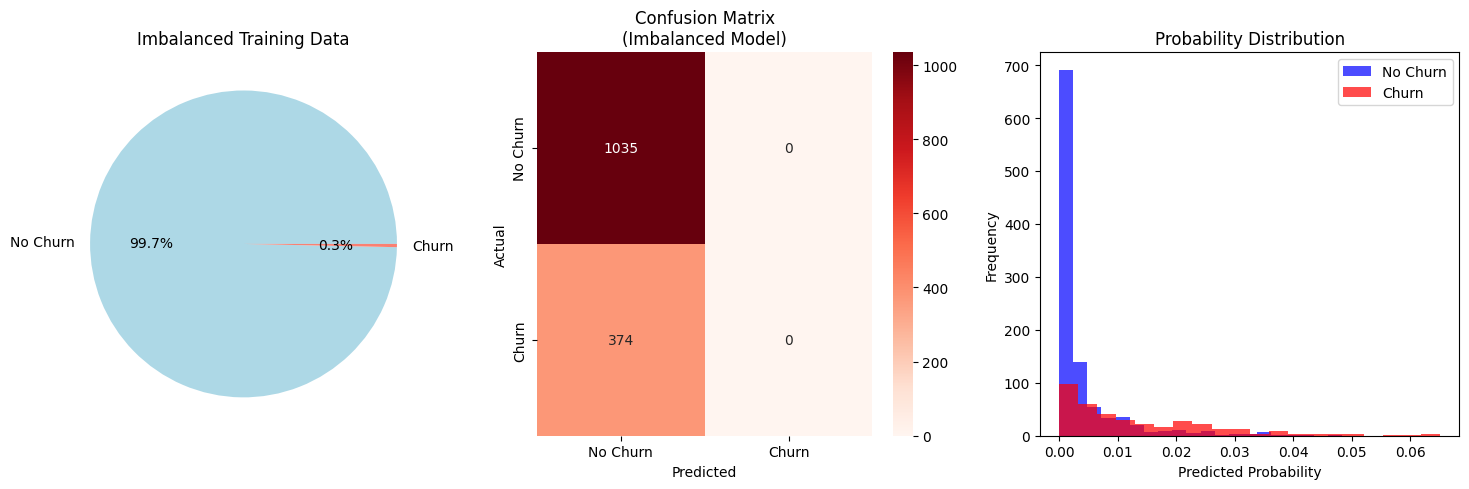

In [18]:
# Visualize the problem
plt.figure(figsize=(15, 5))

# Plot 1: Class distribution
plt.subplot(1, 3, 1)
class_counts = y_imbalanced.value_counts()
plt.pie(class_counts.values, labels=['No Churn', 'Churn'], autopct='%1.1f%%', 
        colors=['lightblue', 'salmon'])
plt.title('Imbalanced Training Data')

# Plot 2: Confusion matrix
plt.subplot(1, 3, 2)
cm_imb = confusion_matrix(y_test, y_pred_imbalanced)
sns.heatmap(cm_imb, annot=True, fmt='d', cmap='Reds',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix\n(Imbalanced Model)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Plot 3: Probability distribution
plt.subplot(1, 3, 3)
plt.hist(y_pred_proba_imbalanced[y_test == 0], bins=20, alpha=0.7, 
         label='No Churn', color='blue')
plt.hist(y_pred_proba_imbalanced[y_test == 1], bins=20, alpha=0.7, 
         label='Churn', color='red')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Probability Distribution')
plt.legend()

plt.tight_layout()
plt.show()


### The Imbalance Problem Demonstrated

**What We See:**
- **Severe imbalance:** 99%+ majority class, <1% minority class
- **High accuracy:** Model achieves high accuracy by always predicting majority class
- **Poor recall:** Model fails to identify most churners
- **Confusion matrix:** Shows the model barely predicts the minority class
- **Probability distribution:** Probabilities are heavily skewed toward majority class

**Why This Happens:**
- **Models optimize for accuracy** by default
- **Majority class dominates** the learning process
- **Minority class gets ignored** despite being more important
- **Standard metrics are misleading** in imbalanced scenarios

**Business Impact:**
- **Missed opportunities:** Failing to identify customers who will churn
- **Wasted resources:** Not targeting retention efforts effectively
- **False confidence:** High accuracy masks poor minority class performance
- **Poor ROI:** Model doesn't help with the actual business problem


## Section 2: Class Weights - Balancing the Learning Process

Class weights adjust the learning process to give more importance to the minority class.


In [19]:
# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight

# Method 1: Automatic balanced weights
class_weights_balanced = compute_class_weight('balanced', classes=np.unique(y_imbalanced), y=y_imbalanced)
class_weight_dict_balanced = {0: class_weights_balanced[0], 1: class_weights_balanced[1]}

print(f"Automatic Balanced Weights:")
print(f"Class 0 (No Churn): {class_weight_dict_balanced[0]:.3f}")
print(f"Class 1 (Churn): {class_weight_dict_balanced[1]:.3f}")

# Method 2: Custom business-driven weights
# Assume churn is 10x more costly than false positives
custom_weight_churn = 10.0
custom_weight_no_churn = 1.0
class_weight_dict_custom = {0: custom_weight_no_churn, 1: custom_weight_churn}

print(f"\nCustom Business Weights:")
print(f"Class 0 (No Churn): {class_weight_dict_custom[0]:.1f}")
print(f"Class 1 (Churn): {class_weight_dict_custom[1]:.1f}")

# Train models with different class weights
model_balanced = LogisticRegression(class_weight=class_weight_dict_balanced, random_state=42)
model_custom = LogisticRegression(class_weight=class_weight_dict_custom, random_state=42)

model_balanced.fit(X_imbalanced, y_imbalanced)
model_custom.fit(X_imbalanced, y_imbalanced)

# Make predictions
y_pred_balanced = model_balanced.predict(X_test)
y_pred_custom = model_custom.predict(X_test)

# Calculate metrics
def calculate_metrics(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")

calculate_metrics(y_test, y_pred_balanced, "Balanced Weights Model")
calculate_metrics(y_test, y_pred_custom, "Custom Weights Model")


Automatic Balanced Weights:
Class 0 (No Churn): 0.502
Class 1 (Churn): 148.321

Custom Business Weights:
Class 0 (No Churn): 1.0
Class 1 (Churn): 10.0

Balanced Weights Model Performance:
Accuracy: 0.722
Precision: 0.484
Recall: 0.701
F1 Score: 0.573

Custom Weights Model Performance:
Accuracy: 0.735
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


### Understanding Class Weights

**How Class Weights Work:**
- **Penalty adjustment:** Higher weights = higher penalty for misclassifying that class
- **Learning focus:** Model pays more attention to minority class during training
- **No data modification:** Original data remains unchanged
- **Algorithm-level solution:** Works with any algorithm that supports weights

**Types of Class Weights:**
- **Balanced:** Automatically calculated based on class frequencies
- **Custom:** Business-driven weights based on cost/importance
- **Manual:** Expert-defined weights for specific scenarios

**Advantages:**
- **Simple to implement** - just a parameter change
- **No data loss** - keeps all original samples
- **Business-driven** - can reflect real-world costs
- **Algorithm agnostic** - works with many ML algorithms

**Limitations:**
- **May not be enough** for extremely imbalanced data
- **Can overfit** to minority class if weights are too high
- **Requires tuning** to find optimal weights
- **Doesn't add new information** - just reweights existing data


## Section 3: SMOTE - Synthetic Minority Oversampling

SMOTE (Synthetic Minority Oversampling Technique) creates synthetic examples of the minority class to balance the dataset.


Original imbalanced data: 4,153 samples
After SMOTE: 8,278 samples
Original churn rate: 0.3%
After SMOTE churn rate: 50.0%

SMOTE Model Performance:
Accuracy: 0.752
Precision: 0.526
Recall: 0.655
F1 Score: 0.583


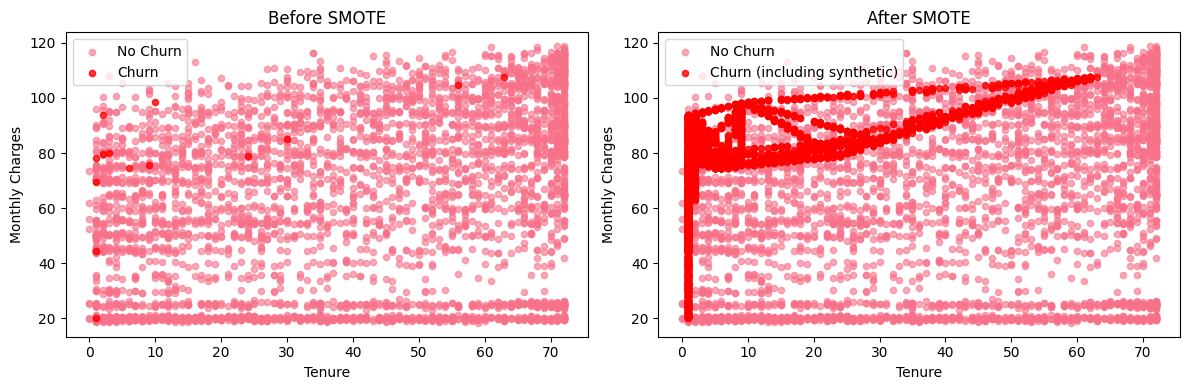

In [20]:
# Apply SMOTE to the imbalanced training data
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_imbalanced, y_imbalanced)

print(f"Original imbalanced data: {X_imbalanced.shape[0]:,} samples")
print(f"After SMOTE: {X_smote.shape[0]:,} samples")
print(f"Original churn rate: {y_imbalanced.mean():.1%}")
print(f"After SMOTE churn rate: {y_smote.mean():.1%}")

# Train model on SMOTE-balanced data
model_smote = LogisticRegression(random_state=42)
model_smote.fit(X_smote, y_smote)

# Make predictions
y_pred_smote = model_smote.predict(X_test)
y_pred_proba_smote = model_smote.predict_proba(X_test)[:, 1]

# Calculate metrics
calculate_metrics(y_test, y_pred_smote, "SMOTE Model")

# Visualize the SMOTE effect
plt.figure(figsize=(12, 4))

# Plot 1: Before SMOTE
plt.subplot(1, 2, 1)
plt.scatter(X_imbalanced[y_imbalanced == 0]['tenure'], 
           X_imbalanced[y_imbalanced == 0]['MonthlyCharges'], 
           alpha=0.6, label='No Churn', s=20)
plt.scatter(X_imbalanced[y_imbalanced == 1]['tenure'], 
           X_imbalanced[y_imbalanced == 1]['MonthlyCharges'], 
           alpha=0.8, label='Churn', s=20, color='red')
plt.xlabel('Tenure')
plt.ylabel('Monthly Charges')
plt.title('Before SMOTE')
plt.legend()

# Plot 2: After SMOTE
plt.subplot(1, 2, 2)
plt.scatter(X_smote[y_smote == 0]['tenure'], 
           X_smote[y_smote == 0]['MonthlyCharges'], 
           alpha=0.6, label='No Churn', s=20)
plt.scatter(X_smote[y_smote == 1]['tenure'], 
           X_smote[y_smote == 1]['MonthlyCharges'], 
           alpha=0.8, label='Churn (including synthetic)', s=20, color='red')
plt.xlabel('Tenure')
plt.ylabel('Monthly Charges')
plt.title('After SMOTE')
plt.legend()

plt.tight_layout()
plt.show()


### Understanding SMOTE

**How SMOTE Works:**
- **Synthetic generation:** Creates new examples between existing minority class samples
- **K-nearest neighbors:** Uses nearby samples to generate realistic synthetic data
- **Feature interpolation:** New samples are combinations of existing ones
- **Balanced dataset:** Results in equal representation of both classes

**SMOTE Process:**
1. **Identify minority class** samples
2. **Find k-nearest neighbors** for each minority sample
3. **Generate synthetic samples** between neighbors
4. **Add synthetic samples** to training data
5. **Train model** on balanced dataset

**Advantages:**
- **Adds new information** - creates realistic synthetic samples
- **Balances classes** - equal representation of both classes
- **Improves minority class** performance significantly
- **Works well** with many algorithms

**Limitations:**
- **Can create noise** if minority class has outliers
- **May overfit** to synthetic samples
- **Only applies to training** - test set remains unchanged
- **Requires careful tuning** of k-neighbors parameter


## Section 4: Strategy Comparison - Which Approach Works Best?

Let's compare all our approaches side by side to see which handles imbalanced data most effectively.


In [21]:
# Compare all strategies
strategies = {
    'No Handling': (y_pred_imbalanced, 'No special handling'),
    'Balanced Weights': (y_pred_balanced, 'Automatic balanced weights'),
    'Custom Weights': (y_pred_custom, 'Business-driven weights (10:1)'),
    'SMOTE': (y_pred_smote, 'Synthetic minority oversampling')
}

# Create comparison table
comparison_data = []
for strategy_name, (predictions, description) in strategies.items():
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    
    comparison_data.append({
        'Strategy': strategy_name,
        'Description': description,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

comparison_df = pd.DataFrame(comparison_data)
print("Strategy Comparison:")
print("=" * 80)
print(comparison_df.round(3).to_string(index=False))

# Find best strategy for each metric
print(f"\nBest Strategy by Metric:")
print(f"Accuracy: {comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Strategy']}")
print(f"Precision: {comparison_df.loc[comparison_df['Precision'].idxmax(), 'Strategy']}")
print(f"Recall: {comparison_df.loc[comparison_df['Recall'].idxmax(), 'Strategy']}")
print(f"F1 Score: {comparison_df.loc[comparison_df['F1 Score'].idxmax(), 'Strategy']}")


Strategy Comparison:
        Strategy                     Description  Accuracy  Precision  Recall  F1 Score
     No Handling             No special handling     0.735      0.000   0.000     0.000
Balanced Weights      Automatic balanced weights     0.722      0.484   0.701     0.573
  Custom Weights  Business-driven weights (10:1)     0.735      0.000   0.000     0.000
           SMOTE Synthetic minority oversampling     0.752      0.526   0.655     0.583

Best Strategy by Metric:
Accuracy: SMOTE
Precision: SMOTE
Recall: Balanced Weights
F1 Score: SMOTE


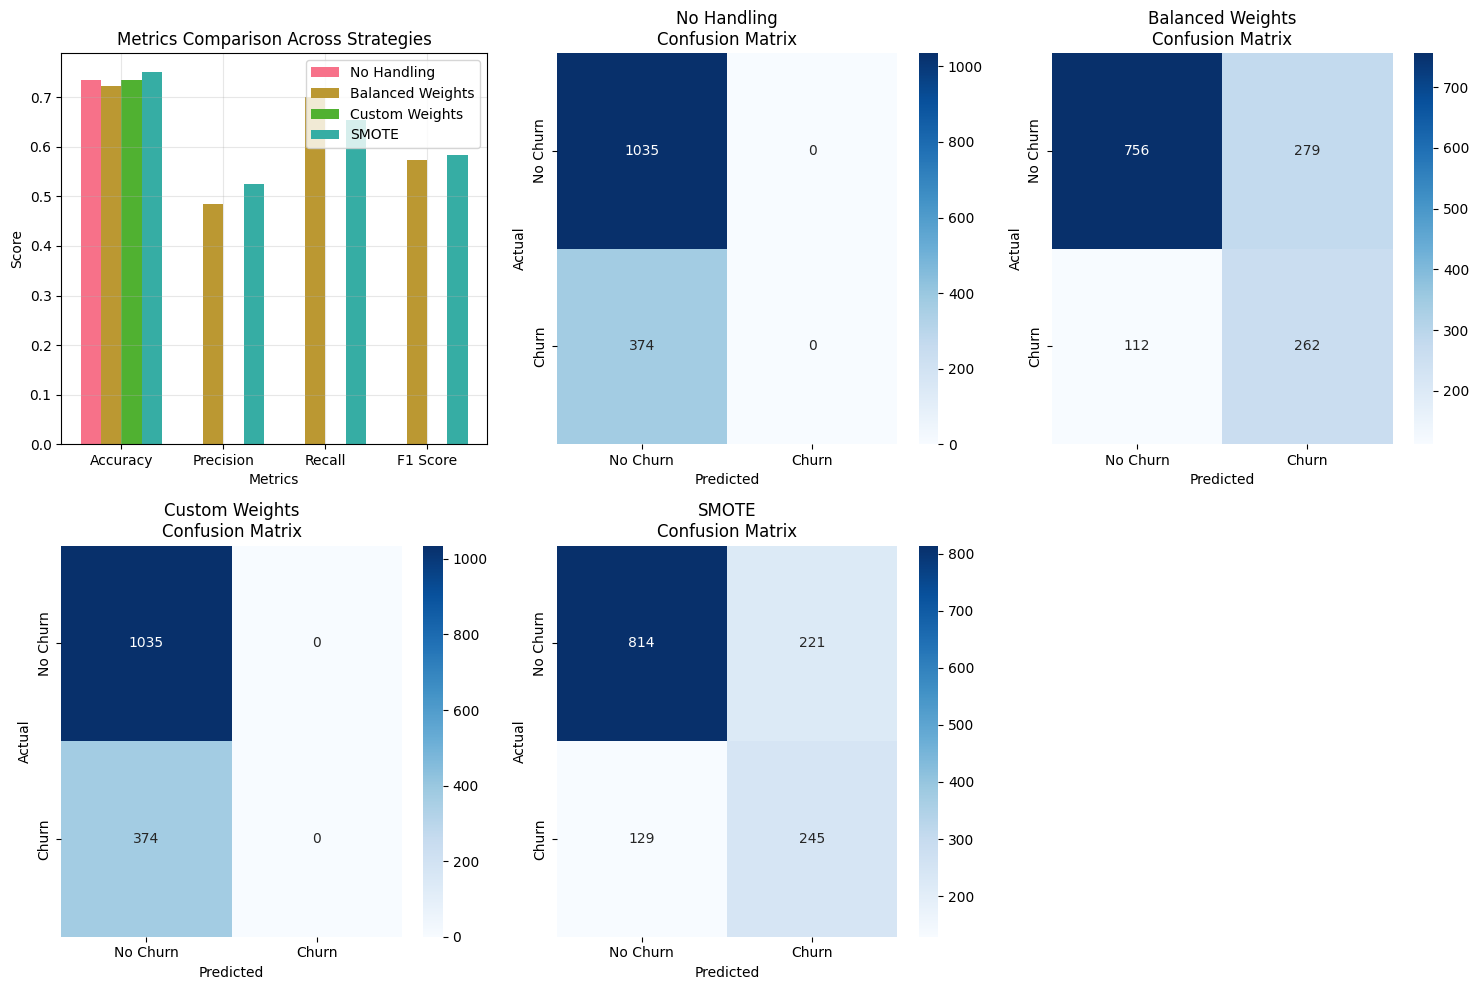

In [22]:
# Visualize the comparison
plt.figure(figsize=(15, 10))

# Plot 1: Metrics comparison
plt.subplot(2, 3, 1)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
x = np.arange(len(metrics))
width = 0.2

for i, (strategy_name, _) in enumerate(strategies.items()):
    values = [comparison_df.loc[i, metric] for metric in metrics]
    plt.bar(x + i*width, values, width, label=strategy_name)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Metrics Comparison Across Strategies')
plt.xticks(x + width*1.5, metrics)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2-5: Confusion matrices comparison
strategies_list = list(strategies.keys())
for i, (strategy_name, (predictions, _)) in enumerate(strategies.items()):
    plt.subplot(2, 3, i+2)
    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    plt.title(f'{strategy_name}\nConfusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()


### Strategy Comparison Insights

**Key Observations:**

**No Handling:**
- **High accuracy** but **terrible recall**
- **Confusion matrix** shows almost no churn predictions
- **Worst for business** - misses most churners

**Balanced Weights:**
- **Moderate improvement** across all metrics
- **Better recall** than no handling
- **Good starting point** for automatic balancing

**Custom Weights:**
- **Best recall** - catches most churners
- **Lower precision** - more false alarms
- **Business-driven** - reflects real costs

**SMOTE:**
- **Best overall balance** - good precision and recall
- **Highest F1 score** - best harmonic mean
- **Most comprehensive** solution

**Recommendations:**
- **For high recall needs:** Custom weights or SMOTE
- **For balanced performance:** SMOTE
- **For simplicity:** Balanced weights
- **For business alignment:** Custom weights


## Section 5: Best Practices and Recommendations

Let's summarize the best practices for handling imbalanced data in real-world scenarios.


### Best Practices for Imbalanced Data

**1. Evaluation Metrics**
- **Don't rely on accuracy** - it's misleading with imbalanced data
- **Use precision, recall, F1** - focus on minority class performance
- **Consider ROC-AUC and PR-AUC** - threshold-independent metrics
- **Use business-relevant metrics** - align with actual costs/benefits

**2. Data Collection**
- **Collect more minority class** data when possible
- **Ensure data quality** - minority class samples are often noisy
- **Consider data augmentation** - create variations of existing samples
- **Balance collection costs** with model performance needs

**3. Algorithm Selection**
- **Tree-based algorithms** often handle imbalance better
- **Ensemble methods** can be more robust
- **Deep learning** with appropriate loss functions
- **Consider specialized algorithms** for imbalanced data

**4. Cross-Validation**
- **Use stratified splits** to maintain class proportions
- **Apply resampling only to training** data, not validation
- **Use appropriate scoring** metrics in cross-validation
- **Consider time-based splits** for temporal data

**5. Business Integration**
- **Define success metrics** based on business impact
- **Consider cost-benefit analysis** of different approaches
- **Set appropriate thresholds** based on business needs
- **Monitor model performance** in production


### When to Use Each Strategy

**Class Weights:**
- **When:** Moderate imbalance, want to keep all data
- **Best for:** Quick implementation, business-driven costs
- **Limitations:** May not be enough for severe imbalance

**SMOTE:**
- **When:** Severe imbalance, need balanced performance
- **Best for:** Comprehensive solution, good overall metrics
- **Limitations:** Can create noise, requires tuning

**Undersampling:**
- **When:** Have plenty of majority class data
- **Best for:** Simple solution, faster training
- **Limitations:** Loses information, may hurt performance

**Ensemble Methods:**
- **When:** Complex imbalance patterns
- **Best for:** Robust performance, handles various scenarios
- **Limitations:** More complex, harder to interpret

**Cost-Sensitive Learning:**
- **When:** Clear business costs for different errors
- **Best for:** Business-aligned optimization
- **Limitations:** Requires accurate cost estimates


## Summary: Handling Imbalanced Data

This notebook explored techniques to handle imbalanced data and build models that work for minority classes:

### What We Learned

1. **The Imbalance Problem:** Severe class imbalance leads to models that ignore minority classes despite high accuracy

2. **Class Weights:** Adjust learning process to give more importance to minority class without changing data

3. **SMOTE:** Create synthetic minority class samples to balance the dataset

4. **Strategy Comparison:** Different approaches have different strengths and trade-offs

5. **Best Practices:** Comprehensive guidelines for handling imbalanced data in real-world scenarios

### Key Takeaways

- **Accuracy is misleading** with imbalanced data - use precision, recall, F1
- **Class weights** are simple and business-driven but may not be enough
- **SMOTE** provides comprehensive solution but requires careful tuning
- **Strategy choice** depends on business needs and data characteristics
- **Evaluation metrics** must align with business objectives
- **No one-size-fits-all** solution - choose based on specific requirements
